**实验目标：**

通过本实验，你将深入了解和实践说话人识别技术，并掌握利用声音特征进行有效说话人识别的基本方法，了解不同特征和模型对识别准确率的影响。

实验的核心目标是使用TIMIT数据集来训练一个说话人识别系统，涵盖数据预处理、特征提取、模型训练和评估等关键步骤。


**实验方法：**

**1. 数据预处理和划分(可选)：**
  - 为了方便大家，我们提供了划分好的TIMIT数据集结构，当然你也可以根据训练结果自行划分该原数据集。
  - 原数据集下载地址：https://drive.google.com/file/d/180mSIiXN9RVDV2Xn1xcWNkMRm5J5MjN4/view?usp=sharing
  - 我们排除了SA的两个方言句子，并在剩余的8个句子中选取了SX的5个句子和SI的1个句子作为训练集，SI的另外2个句子作为测试集。
  
**2. 特征提取：**
  - 学习并实现包括但不限于MFCC特征等特征的提取，探索声音信号的频率和时间特性。
  - 鼓励尝试和比较其他特征提取方法，例如LPCC或声谱图特征，以理解不同特征对识别性能的影响。
  
**3. 模型选择和训练：**
  - 探索并选择适合的分类器和模型进行说话人识别，如GMM、Softmax分类器或深度学习模型。
  - 实现模型训练流程，使用训练集数据训练模型。
  
**4. 评估和分析：**
  - 使用准确率作为主要的评价指标在测试集上评估模型性能。
  - 对比不同特征和模型的性能，分析其对说话人识别准确率的影响。
  - 可视化不同模型的识别结果和错误率，讨论可能的改进方法。

**实验要求：**
  - 1.选择并实现至少一种特征的提取，并鼓励尝试其他特征提取方法。
  - 2.选择并实现至少一种分类器或模型进行说话人识别，并使用准确率评估指标评估其性能。
  - 3.通过实验对比、分析和可视化，撰写详细的实验报告，包括实验目的、实验方法、结果分析和结论。
  - 4.实验报告应以清晰、逻辑性强的形式呈现，图表和结果应清楚明了。

## 1. 实验准备

In [1]:
## 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 可以根据需要导入其他库，比如librosa用于音频处理
import librosa
import librosa.display
import os
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

C:\Users\COOL\Anaconda3\envs\gluon\lib\site-packages\paramiko\transport.py:32: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  from cryptography.hazmat.backends import default_backend


## 2. 数据预处理(加载数据集)

In [4]:
TrainDir = "E2/Dataset/TRAIN"
TestDir = "E2/Dataset/TEST"
## 请在这里写代码加载我们划分好的TIMIT训练集和测试集

# 预处理和特征提取参数
n_mfcc = 13
frame_length = 0.025  # 帧长25ms
frame_stride = 0.01  #帧移10ms

def extract_mfcc(audio_path, n_mfcc, frame_length, frame_stride):
    # 加载音频文件
    signal, sample_rate = librosa.load(audio_path, sr=None)

    # 可以添加更多预处理步骤，如静音移除、预加重等

    # 计算 MFCC 特征
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc,
                                 n_fft=int(sample_rate * frame_length),
                                 hop_length=int(sample_rate * frame_stride))
    return mfccs.T  # 转置是为了将时间维度置于第一维

**调用的librosa.feature.mfcc理解：**  
1. 参数：y是音频信号，sr是采样率，n_mfcc制定了mfcc制定了要提取的MFCC系数的数量，n_fft指定了FFT窗口大小（通过采样率和帧长度计算得到），hop_length指定了帧之间的步长（同样基于采样率和帧长度计算得到）；  

2. 提取出的MFCC数据含义：第一个系数代表整个帧的能量，余下系数代表音频信号的频谱细节，但通过梅尔滤波器组和DCT，它们被转换成了梅尔频率上的倒谱（用于分离信号中的周期性结构{如说话人的声道特征}和非周期信号{噪声}，FT、对数运算、IFT）表示；  

3. librosa.feature.mfcc实现思路：  
    (1) 预加重：高通滤波音频信号，增强高频成分；  
    (2) 窗口化：将音频信号分割成短时帧；  
    (3) FFT：对每一帧信号进行FFT，得到频谱；  
    (4) 梅尔滤波器组：应用一组梅尔刻度滤波器（通常是三角滤波器）到功率谱上，以模拟人耳感知；  
    (5) 取对数：取每个梅尔滤波器输出功率的对数；  
    (6) 离散余弦变换（DCT）：对取对数后的梅尔频谱进行DCT得到MFCC。

## 3. 特征提取

2772 262 13
924 439 13


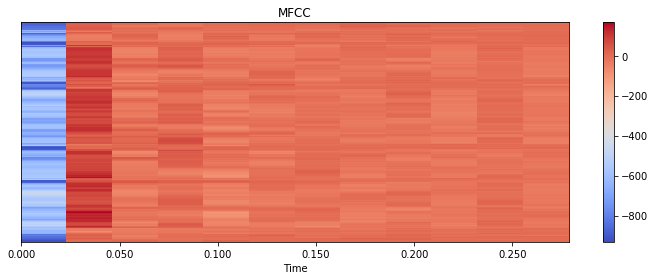

In [68]:
## 请编写或使用库函数提取MFCC等音频特征
# 数据预处理并进行特征提取
def preprocess(root_dir):
    features = []
    labels = []
    speaker_ide = -1
    # 遍历方言地区
    for region_id in os.listdir(root_dir):
        region_path = os.path.join(root_dir, region_id)

        # 遍历说话人
        for speaker_id in os.listdir(region_path):
            speaker_path = os.path.join(region_path, speaker_id)
            speaker_ide += 1
            # 遍历说话人的音频文件
            for audio_file in os.listdir(speaker_path):
                if audio_file.startswith('SX') or audio_file.startswith('SI'):
                    # 提取音频特征
                    mfccs = extract_mfcc(os.path.join(speaker_path, audio_file), n_mfcc, frame_length, frame_stride)
                    features.append(mfccs)
                    labels.append(speaker_ide)
    print(len(features),len(features[10]),len(features[0][0]))
    return features, labels

# mfcc可视化
def visualize_mfcc(mfccs):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()


train_features, train_labels = preprocess(TrainDir)
test_features, test_labels = preprocess(TestDir)

for mfcc_features in train_features:
    visualize_mfcc(mfcc_features)
    break  # 只展示一个

**可视化图表含义：**  
1. 看第一个系数（最下面那行），显示了音频信号的能量变化，这在某种情况下反映了说话的节奏和强度；  

2. 剩余的系数（从底部往上数），反映了信号在梅尔频率上的特性：较低的系数（比如第2个、第3个）捕捉到的是更基本的频率信息，而较高的系数则涉及更复杂的频率形状和变化；  

3. 横轴表示事件变化；  

4. 色彩上，蓝色表示特定频率成分较弱，红色较强。  


In [77]:
## 特征标准化: 确保所有的特征均为1D arrays，并保证长度为max_length
def pad_features(features, max_length):
    padded_features = []
    for f in features:
        if isinstance(f, np.ndarray) and f.ndim == 1:  # Ensuring f is a 1D numpy array
            if len(f) < max_length:
                # Padding
                padded = np.pad(f, (0, max_length - len(f)), mode='constant', constant_values=0)
            else:
                # Truncating if necessary
                padded = f[:max_length]
            padded_features.append(padded)
        else:
            print("Skipping invalid feature")
    return np.stack(padded_features)  # Ensuring to return a proper 2D array

# Converting features to numpy arrays and ensuring they are 1D
train_features = [np.array(f).flatten() if isinstance(f, np.ndarray) else np.array([]) for f in train_features]
test_features = [np.array(f).flatten() if isinstance(f, np.ndarray) else np.array([]) for f in test_features]

# Finding maximum length
max_length = max(max([len(f) for f in train_features if isinstance(f, np.ndarray)]),
                 max([len(f) for f in test_features if isinstance(f, np.ndarray)]))

# Padding features
train_features_padded = pad_features(train_features, max_length)
test_features_padded = pad_features(test_features, max_length)

print("Train features shape:", train_features_padded.shape)
print("Test features shape:", test_features_padded.shape)

# StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(train_features_padded)   #2772*779*13
X_test = scaler.transform(test_features_padded)         #924*779*13
y_train = train_labels
y_test = test_labels




Train features shape: (2772, 10127)
Test features shape: (924, 10127)


## 4.模型训练

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm 
class SpeakerLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(SpeakerLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
      #  self.fc1 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        out, _ = self.lstm(x)
        # out: (batch_size, seq_len, hidden_dim)
        out = out[:, -1, :]  # 取最后一个时间步的输出作为最终输出
        out = self.fc(out)
        # out: (batch_size, num_classes)
        return out

# 示例用法
input_dim = 13  # MFCC特征维度
hidden_dim = 256  # LSTM隐藏层维度
num_layers = 2  # LSTM层数
num_classes = 462  # 说话人类别数

model = SpeakerLSTM(input_dim, hidden_dim, num_layers, num_classes)

# 定义交叉熵损失函数
criterion = nn.CrossEntropyLoss()


# 将原始向量重新组织成一个三维张量
# 1. 将原始向量分割成多个子向量，每个子向量包含 13 个元素
X_train = np.split(X_train, 779, axis=1)
# 2. 将这些子向量按照一定的规律排列成一个大小为 2772x779x13 的张量
X_train = np.stack(X_train, axis=1)

print("Reshaped tensor shape:", X_train.shape)  # 输出：(2772, 779, 13)

batch_size = 22  #22*126=2772
input_data = X_train
labels = y_train
input_data = torch.from_numpy(input_data)
labels = torch.tensor(labels)

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 定义超参数
num_epochs = 300
# 使用 tqdm 添加进度条
for epoch in tqdm(range(num_epochs), desc="Training"):
    # 清零梯度
    optimizer.zero_grad()
    # 前向传播
    outputs = model(input_data)
    # 计算损失
    loss = criterion(outputs, labels)
    # 反向传播
    loss.backward()
    # 更新参数
    optimizer.step()
    # 输出当前迭代的损失
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Reshaped tensor shape: (2772, 779, 13)


Training:   0%|                                                                                | 0/300 [00:00<?, ?it/s]

In [72]:
# 将原始向量重新组织成一个三维张量
# 1. 将原始向量分割成多个子向量，每个子向量包含 13 个元素
X_test = np.split(X_test, 779, axis=1)
# 2. 将这些子向量按照一定的规律排列成一个大小为 2772x779x13 的张量
X_test = np.stack(X_test, axis=1)
X_test = torch.from_numpy(X_test)
y_test = torch.tensor(y_test)
all_predictions = []
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    # 获取预测标签
    _, predictions = torch.max(outputs, 1)
    # 将预测标签和真实标签添加到列表中
    all_predictions.extend(predictions.numpy())

# 计算准确率
accuracy = accuracy_score(y_test, all_predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.0021645021645021645


In [52]:
class VoiceNet(nn.Module):
    def __init__(self, num_classes=2):
        super(VoiceNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=60, kernel_size=7, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=60, out_channels=60, kernel_size=5, stride=2, padding=1)
        
        self.bn1 = nn.BatchNorm2d(num_features=60)
        self.bn2 = nn.BatchNorm2d(num_features=60)
        self.bn3 = nn.BatchNorm2d(num_features=512)
        self.bn5 = nn.BatchNorm1d(num_features=512)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        
        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # Conv2d with weights of size (H, 1) is identical to FC with H weights
        self.conv3 = nn.Conv2d(in_channels=60, out_channels=512, kernel_size=(31, 1))
        self.fc5 = nn.Linear(in_features=512, out_features=512)
        self.fc6 = nn.Linear(in_features=512, out_features=num_classes)
        
    def forward(self, x):
        B, C, H, W = x.size()
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.mpool1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        
        _, _, _, W = x.size()
        self.apool4 = nn.AvgPool2d(kernel_size=(1, W)) # average pooling over time
        x = self.apool4(x)
        
        x = x.flatten(start_dim=1)
        x = self.relu(self.bn5(self.fc5(x)))
        x = self.fc6(x)
        
        # during training, there's no need for SoftMax because CELoss calculates it
        if self.training:
            return x
        else:
            return self.softmax(x)

In [50]:
model = VoiceNet(462)

# 定义交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 示例输入
batch_size = 22  
input_data = X_train
labels = y_train
# 前向传播
input_data = torch.from_numpy(input_data)
labels = torch.tensor(labels)
outputs = model(input_data)

# 计算损失
loss = criterion(outputs, labels)

# 反向传播
loss.backward()

# 更新参数
optimizer.step()


ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
https://blog.csdn.net/qq_39373179/article/details/103788208